In [129]:
import gym
import math
import matplotlib.pyplot as plt

In [2]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""
import math
from typing import Optional, Union

import numpy as np

import gym
from gym import logger, spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled


class CartPole(gym.Env[np.ndarray, Union[int, np.ndarray]]):
    """
    ### Description

    This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in
    ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
    A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
    The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces
     in the left and right direction on the cart.

    ### Action Space

    The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction
     of the fixed force the cart is pushed with.

    | Num | Action                 |
    |-----|------------------------|
    | 0   | Push cart to the left  |
    | 1   | Push cart to the right |

    **Note**: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle
     the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

    ### Observation Space

    The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

    | Num | Observation           | Min                 | Max               |
    |-----|-----------------------|---------------------|-------------------|
    | 0   | Cart Position         | -4.8                | 4.8               |
    | 1   | Cart Velocity         | -Inf                | Inf               |
    | 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
    | 3   | Pole Angular Velocity | -Inf                | Inf               |

    **Note:** While the ranges above denote the possible values for observation space of each element,
        it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:
    -  The cart x-position (index 0) can be take values between `(-4.8, 4.8)`, but the episode terminates
       if the cart leaves the `(-2.4, 2.4)` range.
    -  The pole angle can be observed between  `(-.418, .418)` radians (or **±24°**), but the episode terminates
       if the pole angle is not in the range `(-.2095, .2095)` (or **±12°**)

    ### Rewards

    Since the goal is to keep the pole upright for as long as possible, a reward of `+1` for every step taken,
    including the termination step, is allotted. The threshold for rewards is 475 for v1.

    ### Starting State

    All observations are assigned a uniformly random value in `(-0.05, 0.05)`

    ### Episode End

    The episode ends if any one of the following occurs:

    1. Termination: Pole Angle is greater than ±12°
    2. Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
    3. Truncation: Episode length is greater than 500 (200 for v0)

    ### Arguments

    ```
    gym.make('CartPole-v1')
    ```

    No additional arguments are currently supported.
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 50,
    }

    def __init__(self, render_mode: Optional[str] = None):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.5
        self.total_mass = self.masspole + self.masscart
        self.length = 0.25  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = 15.0
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = "euler"
        #self.initial_angle = 25*math.pi/180


        # Angle at which to fail the episode
        self.theta_threshold_radians = 180*math.pi/180
        self.x_threshold = 0.5

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = np.array(
            [
                self.x_threshold * 2,
                np.finfo(np.float32).max,
                self.theta_threshold_radians * 2,
                np.finfo(np.float32).max,
            ],
            dtype=np.float32,
        )

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True
        self.state = None

        self.steps_beyond_terminated = None

    def step(self, action):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg
        assert self.state is not None, "Call reset before using step method."
        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * theta_dot**2 * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta**2 / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == "euler":
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)

        terminated = bool(
            x < -1*self.x_threshold
            or x > 1*self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        if not terminated:
            reward = 1.0
        elif self.steps_beyond_terminated is None:
            # Pole just fell!
            self.steps_beyond_terminated = 0
            reward = 1.0
        else:
            if self.steps_beyond_terminated == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned terminated = True. You "
                    "should always call 'reset()' once you receive 'terminated = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_terminated += 1
            reward = 0.0

        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), reward, terminated, False, {}

    def reset(self,*,seed: Optional[int] = None,options: Optional[dict] = None,start_angle: Optional[float] = None,):
        super().reset(seed=seed)
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        
        low, high = utils.maybe_parse_reset_bounds(
            options, -0.05, 0.05 ) # default low        )  # default high

        if start_angle is not None:
            assert -self.theta_threshold_radians <= start_angle <= self.theta_threshold_radians, \
                "Starting angle must be within the allowed range"
            self.state = np.array([0.0, 0.0, start_angle, 0.0])
        else:
            self.state = self.np_random.uniform(low=low, high=high, size=(4,))

        self.steps_beyond_terminated = None
        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[classic_control]`"
            )

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode == "rgb_array"
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.x_threshold * 2
        scale = self.screen_width / world_width
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0

        if self.state is None:
            return None

        x = self.state

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
        axleoffset = cartheight / 4.0
        cartx = x[0] * scale + self.screen_width / 2.0  # MIDDLE OF CART
        carty = 100  # TOP OF CART
        cart_coords = [(l, b), (l, t), (r, t), (r, b)]
        cart_coords = [(c[0] + cartx, c[1] + carty) for c in cart_coords]
        gfxdraw.aapolygon(self.surf, cart_coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, cart_coords, (0, 0, 0))

        l, r, t, b = (
            -polewidth / 2,
            polewidth / 2,
            polelen - polewidth / 2,
            -polewidth / 2,
        )

        pole_coords = []
        for coord in [(l, b), (l, t), (r, t), (r, b)]:
            coord = pygame.math.Vector2(coord).rotate_rad(-x[2])
            coord = (coord[0] + cartx, coord[1] + carty + axleoffset)
            pole_coords.append(coord)
        gfxdraw.aapolygon(self.surf, pole_coords, (202, 152, 101))
        gfxdraw.filled_polygon(self.surf, pole_coords, (202, 152, 101))

        gfxdraw.aacircle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )
        gfxdraw.filled_circle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )

        gfxdraw.hline(self.surf, 0, self.screen_width, carty, (0, 0, 0))

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False

In [3]:
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0
        self.integral = 0
    def control(self, error):
        self.integral += error
        derivative = (error - self.prev_error)/0.02
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        return output

In [128]:
import time
#| 0   | Push cart to the left  |
#| 1   | Push cart to the right |
env = CartPole(render_mode='human')
env.force_mag = 10.0
env.x_threshold = 0.5
X = []
angle = []
position = []
duration = 60
angle_controller = PIDController(Kp=12.115 ,Ki= 0.2,Kd=2)
position_controller = PIDController(Kp=0.5, Ki=0.001, Kd=1.5)

for episode in range(1):
    observation = env.reset(start_angle = 20*math.pi/180)[0]
    start_time = time.time()
    while True:
        env.render()
        angle_error = observation[2]  # Angle error
        position_error = observation[0] #position error
        angle.append(angle_error)
        position.append(position_error)
        X.append(counter)
        angle_output = angle_controller.control(angle_error)
        position_output = position_controller.control(position_error)
        total_output = angle_output + position_output
        if total_output<0:
            action = 0
        else:
            action = 1
        observation, reward, done, _, _ = env.step(action)
        if time.time() - start_time >= duration:
            break  
        if (time.time()-start_time>=10 and observation[2]<=5*math.pi/180 and observation[2]>=-5*math.pi/180):
             env.force_mag = 5
        else:
             env.force_mag = 10
env.close()

C:\Users\Erfan\AppData\Local\Temp\ipykernel_15816\793935140.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


KeyboardInterrupt: 

In [107]:
angle = np.array(angle)
X = np.array(X)
position = np.array(position)
angles = angle*180/math.pi

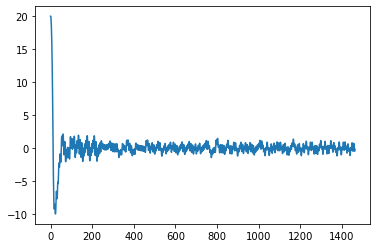

In [109]:
plt.plot(X,angles)

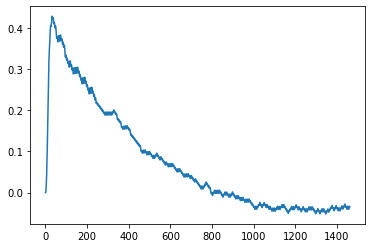

In [110]:
plt.plot(X,position)

In [112]:
np.savetxt("PIDAngle20.csv", angles, delimiter=",")
np.savetxt("PIDxAngle20.csv", X, delimiter=",")
np.savetxt("PIDpositionAngle20.csv", position, delimiter=",")